# Gravity Density Model

Adapted from [gravity forward code](https://github.com/inlab-geo/inversion-test-problems/blob/main/GravityForward.ipynb) written in inversion-test-problems

---
### 0. Import modules

In [25]:
import numpy as np
import matplotlib.pyplot as plt

from cofi import BaseProblem, InversionOptions, Inversion

np.random.seed(42)

### 0. Auxillary functions

In [26]:
def kernel(ii,jj,kk,dx,dy,dz,dim):
    
    r = (dx[:, ii] ** 2 + dy[:, jj] ** 2 + dz[:, kk]** 2) ** (0.50)

    dz_r = dz[:, kk] + r
    dy_r = dy[:, jj] + r
    dx_r = dx[:, ii] + r

    dxr = dx[:, ii] * r
    dyr = dy[:, jj] * r
    dzr = dz[:, kk] * r
    
    dydz = dy[:, jj] * dz[:, kk]
    dxdy = dx[:, ii] * dy[:, jj]
    dxdz = dx[:, ii] * dz[:, kk]
    
    if dim=="gx":
        g = (-1) ** (ii + jj + kk) * (dy[:, jj] * np.log(dz_r) + dz[:, kk]* np.log(dy_r) - dx[:, ii] * np.arctan(dydz / dxr))
    elif dim=="gy":
        g = (-1) ** (ii + jj + kk) * (dx[:, ii] * np.log(dz_r) + dz[:, kk]* np.log(dx_r) - dy[:, jj] * np.arctan(dxdz / dyr))
    elif dim=="gz":
        g = (-1) ** (ii + jj + kk) * (dx[:, ii] * np.log(dy_r) + dy[:, jj] * np.log(dx_r) - dz[:, kk]* np.arctan(dxdy / dzr))
    elif dim=="gxx":
        arg = dy[:, jj] * dz[:, kk] / dxr
        # It said g-= ... - maybe neet to switch vorzeichen?
        g = ((-1) ** (ii + jj + kk) * (dxdy / (r * dz_r)+ dxdz / (r * dy_r)- np.arctan(arg)+ dx[:, ii]* (1.0 / (1 + arg ** 2.0))* dydz/ dxr ** 2.0* (r + dx[:, ii] ** 2.0 / r)))
    elif dim=="gxy":
        arg = dy[:, jj] * dz[:, kk] / dxr
        g = ((-1) ** (ii + jj + kk) * (np.log(dz_r)+ dy[:, jj] ** 2.0 / (r * dz_r)+ dz[:, kk] / r- 1.0/ (1 + arg ** 2.0)* (dz[:, kk] / r ** 2)* (r - dy[:, jj] ** 2.0 / r)))
    elif dim=="gxz":
        arg = dy[:, jj] * dz[:, kk] / dxr
        g = ((-1) ** (ii + jj + kk) * (np.log(dy_r)+ dz[:, kk] ** 2.0 / (r * dy_r)+ dy[:, jj] / r- 1.0/ (1 + arg ** 2.0)* (dy[:, jj] / (r ** 2))* (r - dz[:, kk] ** 2.0 / r)))
    elif dim=="gyy":
        arg = dx[:, ii] * dz[:, kk] / dyr
        g = ((-1) ** (ii + jj + kk) * (dxdy / (r * dz_r)+ dydz / (r * dx_r)- np.arctan(arg)+ dy[:, jj]* (1.0 / (1 + arg ** 2.0))* dxdz/ dyr ** 2.0* (r + dy[:, jj] ** 2.0 / r)))
    elif dim=="gyz":
        arg = dx[:, ii] * dz[:, kk] / dyr
        g = ((-1) ** (ii + jj + kk) * (np.log(dx_r)+ dz[:, kk] ** 2.0 / (r * (dx_r))+ dx[:, ii] / r- 1.0/ (1 + arg ** 2.0)* (dx[:, ii] / (r ** 2))* (r - dz[:, kk] ** 2.0 / r)))
    elif dim=="gzz":
        arg = dy[:, jj] * dz[:, kk] / dxr
        gxx = ((-1) ** (ii + jj + kk) * (dxdy / (r * dz_r)+ dxdz / (r * dy_r)- np.arctan(arg)+ dx[:, ii]* (1.0 / (1 + arg ** 2.0))* dydz/ dxr ** 2.0* (r + dx[:, ii] ** 2.0 / r)))
        arg = dx[:, ii] * dz[:, kk] / dyr
        gyy = ((-1) ** (ii + jj + kk) * (dxdy / (r * dz_r)+ dydz / (r * dx_r)- np.arctan(arg)+ dy[:, jj]* (1.0 / (1 + arg ** 2.0))* dxdz/ dyr ** 2.0* (r + dy[:, jj] ** 2.0 / r)))
        g=-gxx-gyy
    return g

def calculate_gravity(model, x_final, y_final, z_final, recvec, jacobian=False, return_both=False):
    if return_both==True:
        jacobian=True
    from scipy.constants import G as G    
    # Tolerance implementation follows SimPEG, discussed in Nagy et al., 2000
    tol=1e-4

    gx_rec=np.zeros(len(recvec))
    gy_rec=np.zeros(len(recvec))
    gz_rec=np.zeros(len(recvec))
    
    if jacobian==True:
        Jx_rec=np.zeros([len(recvec),len(x_final)])
        Jy_rec=np.zeros([len(recvec),len(x_final)])
        Jz_rec=np.zeros([len(recvec),len(x_final)])

    
    for recno in range(len(recvec)):

        dx=x_final-recvec[recno,0]
        dy=y_final-recvec[recno,1]
        dz=z_final-recvec[recno,2]

        min_x=np.min(np.diff(dx))
        min_y=np.min(np.diff(dy))
        min_z=np.min(np.diff(dz))

        dx[np.abs(dx) / min_x < tol] = tol * min_x
        dy[np.abs(dy) / min_y < tol] = tol * min_y
        dz[np.abs(dz) / min_z < tol] = tol * min_z

        Jx=0
        Jy=0
        Jz=0

        for ii in range(2):
            for jj in range(2):
                for kk in range(2):

                    # gx, gy apppear to work, but need confcirmation.
                    # gz is tested and works
                    Jx+=kernel(ii,jj,kk,dx,dy,dz,"gx")
                    Jy+=kernel(ii,jj,kk,dx,dy,dz,"gy")
                    Jz+=kernel(ii,jj,kk,dx,dy,dz,"gz")
                        
        
        # Multiply J (Nx1) with the model density (Nx1) element-wise
        gx_rec[recno] = 1e5*G*sum(model*Jx)
        gy_rec[recno] = 1e5*G*sum(model*Jy)
        gz_rec[recno] = 1e5*G*sum(model*Jz)
        
        if jacobian==True:
            Jx_rec[recno,:] = Jx
            Jy_rec[recno,:] = Jy
            Jz_rec[recno,:] = Jz
            
    if jacobian==False:    
        return gx_rec, gy_rec, gz_rec
    elif return_both==True:
        return gx_rec, gy_rec, gz_rec, Jx_rec,  Jy_rec,  Jz_rec
    else: 
        return Jx_rec,  Jy_rec,  Jz_rec
    
def calculate_gradiometry(model, x_final, y_final, z_final, recvec):

    # Tolerance implementation follows SimPEG, discussed in Nagy et al., 2000
    tol=1e-4

    gxx_rec=np.zeros(len(recvec))
    gxy_rec=np.zeros(len(recvec))
    gxz_rec=np.zeros(len(recvec))
    gyy_rec=np.zeros(len(recvec))
    gyz_rec=np.zeros(len(recvec))
    gzz_rec=np.zeros(len(recvec))

    for recno in range(len(recvec)):

        dx=x_final-recvec[recno,0]
        dy=y_final-recvec[recno,1]
        dz=z_final-recvec[recno,2]

        min_x=np.min(np.diff(dx))
        min_y=np.min(np.diff(dy))
        min_z=np.min(np.diff(dz))

        dx[np.abs(dx) / min_x < tol] = tol * min_x
        dy[np.abs(dy) / min_y < tol] = tol * min_y
        dz[np.abs(dz) / min_z < tol] = tol * min_z

        Jxx=0
        Jxy=0
        Jxz=0
        Jyy=0
        Jyz=0
        Jzz=0
        
        for ii in range(2):
            for jj in range(2):
                for kk in range(2):
                    
                    # Gradiometry kernels NOT checked yet. Just look good.
                    Jxx+=kernel(ii,jj,kk,dx,dy,dz,"gxx")
                    Jxy+=kernel(ii,jj,kk,dx,dy,dz,"gxy")
                    Jxz+=kernel(ii,jj,kk,dx,dy,dz,"gxz")
                    Jyy+=kernel(ii,jj,kk,dx,dy,dz,"gyy")
                    Jyz+=kernel(ii,jj,kk,dx,dy,dz,"gyz")
                    Jzz+=kernel(ii,jj,kk,dx,dy,dz,"gzz")

                    
        # Multiply J (Nx1) with the model density (Nx1) element-wise
        gxx_rec[recno] = 1e8*G*sum(model*Jxx)
        gxy_rec[recno] = 1e8*G*sum(model*Jxy)
        gxz_rec[recno] = 1e8*G*sum(model*Jxz)
        gyy_rec[recno] = 1e8*G*sum(model*Jyy)
        gyz_rec[recno] = 1e8*G*sum(model*Jyz)
        gzz_rec[recno] = 1e8*G*sum(model*Jzz)
    
    
    return gxx_rec, gxy_rec, gxz_rec, gyy_rec, gyz_rec, gzz_rec 
 
# class modelclass(object):
#     def __init__(self, **kwargs):
#         self.__dict__.update(kwargs)

# # Don't know how to use this yet:
# class gravity(BaseProblem):
#     def __init__(self, x_nodes, y_nodes, z_nodes, recvec):
#         self.x_nodes=x_nodes
#         self.y_nodes=y_nodes
#         self.z_nodes=z_nodes
#         self.recvec=recvec
        
    
# -----------------------------------------------------
# New functions, defined just for CoFI
# The ones above are from my forward code. 
# Only difference between these two is "jacobian=True", but necessary here to separate them

def forward(model):
    # Load model geometry 
    P=np.load('Gravity_model.npz')
    x_nodes = P['x_nodes']
    y_nodes = P['y_nodes']
    z_nodes=P['z_nodes']
    rec_coords=P['rec_coords']
    
    gx, gy, gz = calculate_gravity(model,x_nodes,y_nodes,z_nodes,rec_coords)
    
    return gz
        
        
def get_jacobian(model):
    # Load model geometry 
    P=np.load('Gravity_model.npz')
    x_nodes = P['x_nodes']
    y_nodes = P['y_nodes']
    z_nodes=P['z_nodes']
    rec_coords=P['rec_coords']
    
    Jx, Jy, Jz = calculate_gravity(model,x_nodes,y_nodes,z_nodes,rec_coords, jacobian=True)
    
    return Jz

def depth_weight(z,z0,beta):
    return ((-z[::-1]+z0)**(-beta/2))


def reg_l1(model):
    return np.linalg.norm(W @ model, 1)

def reg_l2(model):
    return np.linalg.norm(W @ model, 2)

def reg_gradient_l1(model):
    return W @ np.sign(model)

def reg_gradient_l2(model):
    return 2 * m.T @ W.T @ W

---
### 1. Define the problem

I took out gx, gy for now to make it more straight forward. We can add all kinds of things once it is working. 

In [27]:
# Load density model
tmp=np.load('Gravity_model.npz')
rec_coords=tmp['rec_coords']
z_nodes=tmp['z_nodes']
model=tmp['model']
del tmp

# Load starting models
tmp=np.load('Starting_models.npz')
Starting_model1=tmp['starting_model1']
# Starting_model1[Starting_model1 > 0 ]=10
Starting_model2=tmp['starting_model2']
# Starting_model2 = np.zeros((12**3))

# Create "observed" data by adding noise to forward solution
noise_level=0.05
gz = forward(model)
dataZ_obs= gz + np.random.normal(loc=0,scale=noise_level*np.max(np.abs(gz)),size=np.shape(gz))  

# Create jacobian
Jz = get_jacobian(model)

# Define depth weighting values
z0=18.6
beta=2
# Define regularization parameter
epsilon=0.2

# Create regularization
# Calculate depth weighting fcn - high values at low z, low values at high z, no zeros.
# Model is [Nx1] with N: no. of cells; W is [NxN] with weighting values on diagonal
W=depth_weight(z_nodes[:,0],z0,beta)
W=np.diag(W)

# Set CoFI problem:
grav_problem = BaseProblem()
grav_problem.name = "Gravity"
grav_problem.set_dataset(rec_coords, gz)

# Here I linked the function, not the result
grav_problem.set_forward(forward)

# Here I linked to the actual jacobian. Jacobian size is (MxN) with M: receiver and N: model cells
grav_problem.set_jacobian(Jz)

# Set regularization; reg is a function that takes the model as input
grav_problem.set_regularisation(reg_l1, epsilon)

# Use default L2 misfit
grav_problem.set_data_misfit("L2")
grav_problem.set_initial_model(Starting_model1)

# Set gradient, in hope of helping optimisers converge better
def data_misfit_gradient(model):
    return 2* Jz.T @ (forward(model) - gz) / gz.shape[0]
grav_problem.set_gradient(lambda m: data_misfit_gradient(m) + epsilon*reg_gradient_l1(m))

grav_problem.summary()

Summary for inversion problem: Gravity
Model shape: (1728,)
---------------------------------------------------------------------
List of functions/properties set by you:
['gradient', 'jacobian', 'regularisation', 'forward', 'dataset', 'initial_model', 'model_shape']
---------------------------------------------------------------------
List of functions/properties created based on what you have provided:
['objective', 'residual', 'jacobian_times_vector', 'data_misfit']
---------------------------------------------------------------------
List of functions/properties not set by you:
['objective', 'hessian', 'hessian_times_vector', 'residual', 'jacobian_times_vector', 'data_misfit', 'bounds', 'constraints']


---
### 2. Define the inversion

In [28]:
inv_options = InversionOptions()
# inv_options.set_tool()
# inv_options.set_params()
inv_options.set_tool("scipy.linalg.lstsq")

inv_options.summary()

Summary for inversion options
Solving method: None set
Use `suggest_solving_methods()` to check available solving methods.
-----------------------------
Backend tool: `scipy.linalg.lstsq` - SciPy's wrapper function over LAPACK's linear least-squares solver, using 'gelsd', 'gelsy' (default), or 'gelss' as backend driver
References: ['https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html', 'https://www.netlib.org/lapack/lug/node27.html']
Use `suggest_tools()` to check available backend tools.
-----------------------------
Solver-specific parameters: None set
Use `suggest_solver_params()` to check required/optional solver-specific parameters.


---
## 3. Start an inversion runner

In [29]:
inv = Inversion(grav_problem, inv_options)
# inv.summary()

In [30]:
inv_result = inv.run()
inv_result.summary()

Summary for inversion result
SUCCESS
----------------------------
model: [ 4.06301416e-05  4.94069809e-05  3.41756548e-05 ... -1.65117772e-07
 -1.05837900e-05 -1.23984518e-05]
sum of squared residuals: []
effective rank: 400
singular values: [6.54594020e+02 4.69819191e+02 4.69819191e+02 4.16475774e+02
 1.53761377e+02 1.14183816e+02 1.14183816e+02 9.41470345e+01
 7.10885006e+01 6.68366030e+01 6.68366030e+01 6.48378949e+01
 5.21430450e+01 5.17341610e+01 5.17341610e+01 5.12804320e+01
 4.41749161e+01 4.40441203e+01 4.40441203e+01 4.38569143e+01
 4.09674397e+01 4.08687940e+01 4.08687940e+01 4.08406916e+01
 3.80586983e+01 3.64630917e+01 3.64630917e+01 3.64525515e+01
 3.64445131e+01 3.41256447e+01 3.41256447e+01 3.25692236e+01
 2.86515514e+01 1.98871632e+01 1.98871632e+01 1.69314921e+01
 1.68577787e+01 1.61104268e+01 1.61104268e+01 1.55314622e+01
 1.53674082e+01 1.44704540e+01 1.44704540e+01 1.35166251e+01
 1.35166251e+01 1.32037151e+01 1.30333511e+01 1.29754815e+01
 1.29440190e+01 1.25963948

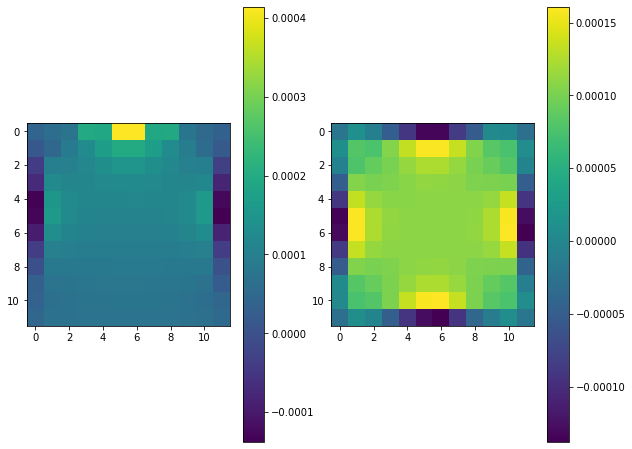

In [31]:
result_model = inv_result.model.reshape(12,12,12)

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(121)
img1 = ax1.imshow(result_model[::-1,6,:])
plt.colorbar(img1)
ax2 = fig.add_subplot(122)
img2 = ax2.imshow(result_model[6,:,:])
plt.colorbar(img2);